In [1]:
#Just getting dependencies
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Image tools and params

In [4]:
content_learning_rate = 1
style_learning_rate = 100000 #The gradients for style are very small, which is why this is so big
input_size = (500,500) #Height by width of content, style, and output image. 
num_iters = 100 #How many steps to perform while transferring input image

In [5]:
#Need these for manipulating images
resize_convert = torchvision.transforms.Compose([
    torchvision.transforms.Resize(input_size[0]), #Resize the smaller dimension to 224
    torchvision.transforms.CenterCrop(input_size[0]), #Height / width of new image
    torchvision.transforms.ToTensor(),
])
imageDisp = torchvision.transforms.ToPILImage()

def image_loader(path, resize=False): 
    image = Image.open(path)
    image = resize_convert(image)
    image = image.unsqueeze(0) #This adds a 'fake batch dimension of 1' at the 0th dimension
    return image.to(device, torch.float) #sends float tensor off to the device

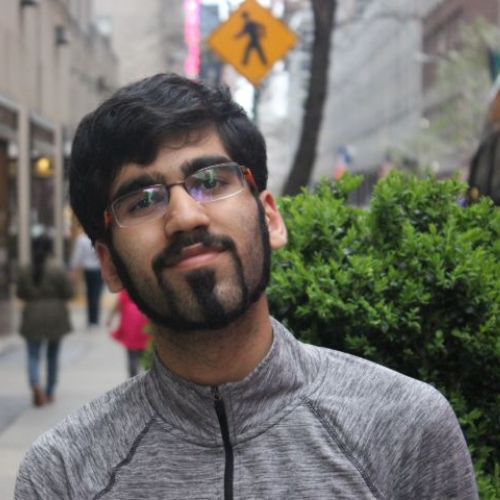

In [15]:
#Insert your own content image paths here
generated = image_loader('[insert style content path here]')
content = image_loader('[insert style content path here]')
imageDisp(content[0])

## Loading pretrained models / custom layers

Just run this block - it loads a pretrained VGG11 model from Pytorch

**IMPORTANT:** You need to download the weights from [here](https://download.pytorch.org/models/vgg11-8a719046.pth). You'll get a .pth file. Add the filepath to that file where it says `checkpoint = '[INSERT YOUR FILEPATH HERE]'`

In [7]:
import torch.nn as nn
from typing import Union, List, Dict, Any, cast


__all__ = [
    'VGG', 'vgg11'
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-8a719046.pth',
}


class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        #x = torch.flatten(x, 1)
        #x = self.classifier(x) - skip neural net layers. 
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}


def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        checkpoint = "/kaggle/input/vgg11weights/vgg11-8a719046.pth" #PUT YOUR FILEPATH HERE
        state_dict = torch.load(checkpoint)
        model.load_state_dict(state_dict)
    return model



def vgg11(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)

Just run this block too - it loads custom layers to compute the content and style costs. 

In [9]:
#Compute Content cost
class ContentLoss(nn.Module):
    def __init__(self, C_encoding):
        super(ContentLoss, self).__init__()
        self.C_encoding = C_encoding.detach() #Don't track graph changes
        
    def forward(self, G_encoding):
        self.C_loss = torch.nn.functional.mse_loss(self.C_encoding, G_encoding)
        return G_encoding

#Compute style cost
def gram_matrix(X):
    batch_size, num_channels, height, width = X.size()
    
    #Resize matrix so all batches next to each other and height x width is flattened
    arr_by_channels = X.view(batch_size * num_channels, height * width)
    
    G = torch.mm(arr_by_channels, arr_by_channels.t()) #Matrix multiplication
    G = G / (batch_size * num_channels * height * width) #Divide by num els to normalise
    
    return G

class StyleLoss(nn.Module):
    def __init__(self, S_encoding):
        super(StyleLoss, self).__init__()
        self.S_style = gram_matrix(S_encoding).detach() #Don't track graph changes
        
    def forward(self, G_encoding):
        G_style = gram_matrix(G_encoding)
        self.S_loss = torch.nn.functional.mse_loss(self.S_style, G_style)
        return G_encoding
    
#Prep pretrained model
cnn = vgg11(pretrained = True).features.to(device).eval() #select only feature layers of model
norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) #specified by Pytorch's VGG11 model docs
norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

#Make custom normalisation class to put in torch.nn.Sequential object
class Normalisation(nn.Module):
    def __init__(self, mean, std):
        super(Normalisation, self).__init__()
        
        #Go from 1D tensor, N long --> N x 1 x 1 tensor (dims match w/ images for broadcasting)
        self.mean = torch.clone(mean).detach().view(-1, 1, 1)
        self.std = torch.clone(std).detach().view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

Sidenote: I think the 'forward' function in a torch.nn.Module class is special in Pytorch. I'd like to name the functions 'loss' because they seem to me to be computing the loss. And I thought it was weird that we were passing the encoding into the functions instead of computing that alongside the loss. 

The reason for these things is so **we can put all these custom modules in a torch.nn.Sequential() object**. After each CNN layer, we'll insert the content and style cost functions. So they'll automatically be passed the encodings from previous layers. And they need to return the encodings again so they get passed on to the next layers. 

### This function puts the layers from above in the right order
Just run the block to load it

In [ ]:
content_layers = ['conv_3']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4']

def get_model(cnn, norm_mean, norm_std, style, content, content_layers, style_layers):
    #Build custom normalisation module
    norm = Normalisation(norm_mean, norm_std).to(device)
    
    #Just keep track of these for later
    content_loss_layers = []
    style_loss_layers = []
    
    model = torch.nn.Sequential(norm) #we'll add more layers while going through cnn
    
    i = 0 #Use this counter for every conv layer we see
    for layer in cnn.children(): #.children() is like .modules()
        #We must name modules to add them to torch.nn.Sequential using .add_module()
        name = ""
        if isinstance(layer, torch.nn.Conv2d):
            name = "conv_" + str(i)
            i += 1
        elif isinstance(layer, torch.nn.MaxPool2d):
            name = "pool_" + str(i)
        elif isinstance(layer, torch.nn.ReLU):
            layer = torch.nn.ReLU(inplace=False) #it doesn't modify inputs in place. Copies them first
            name = "relu_" + str(i)
        
        model.add_module(name, layer)
        
        if name in content_layers:
            #Precompute encoding up to this point
            C_encoding = model(content).detach() #Don't need computation graph history from forward pass
            loss_comp = ContentLoss(C_encoding)
            layer_name = "c_loss_" + str(i)
            
            model.add_module(layer_name, loss_comp)
            content_loss_layers.append(loss_comp)
        if name in style_layers:
            #Precompute encoding up to this point
            S_encoding = model(style).detach()
            loss_comp = StyleLoss(S_encoding)
            layer_name = "s_loss_" + str(i)
            
            model.add_module(layer_name, loss_comp)
            style_loss_layers.append(loss_comp)
   
    #Finally, get rid of any layers added to torch.nn.Sequential after the last content/style loss
    for l in range(len(model) - 1, 0, -1): #Going from last to first layer
        if isinstance(model[l], ContentLoss) or isinstance(model[l], StyleLoss):
            break #As soon as you see a content/style loss, stop
    model = model[0 : (l+1)] #Model = all layers from beginning up to and including that one
    
    return model, content_loss_layers, style_loss_layers

## Defining Gradient Descent / Training
Just run the block below to load the function

In [11]:
def train(cnn, norm_mean, norm_std, style, content, generated, content_layers, style_layers, \
         num_steps=100, style_weight=100000, content_weight=1):
    
    print('Building model')
    model, c_loss_layers, s_loss_layers = \
        get_model(cnn, norm_mean, norm_std, style, content, content_layers, style_layers)
    
    #Set image pixels as params, but model params as fixed
    generated.requires_grad_(True)
    model.requires_grad_(False) #Weird how you can just set the model to not require grad, not its params
    optimiser = torch.optim.LBFGS([generated])
    
    print('Training')
    run = [0] #So this is out of scope from closure. But we can get around that by creating an array (b/c it points to memory location?)
    cost_history = []
    while run[0] <= num_steps:
        #Closure function is used by L-BFGS to check loss multiple times to check for convergence
        def closure(): #This function must reset grad, compute loss, run backprop, and return loss
            print(".", end="")
            run[0] += 1
            with torch.no_grad():
                generated.clamp_(0,1) #If pixel value < 0, set it to 0. If > 1, set it to 1
            
            #Compute loss
            optimiser.zero_grad()
            model(generated) #We don't need to save result b/c model saves losses along the way in self.loss
            
            #Retrieve loss
            style_loss = 0
            content_loss = 0
            for l in s_loss_layers:
                style_loss = style_loss + l.S_loss #Some of these layers turn out not to have S_loss set?
            for l in c_loss_layers:
                content_loss = content_loss + l.C_loss

            #Aggregate / return loss
            loss = style_loss * style_weight + content_loss * content_weight
            cost_history.append(loss.clone())
            loss.backward()
            return style_loss * style_weight + content_loss * content_weight #Not sure why we return new copy
        
        optimiser.step(closure)
    
    #Correct image pixels one last time
    with torch.no_grad():
        generated.clamp_(0, 1)

    return generated, cost_history

## Run the model
**Important:** Change the style image and output folder paths. 

In [14]:
styles_full = ['lines.jpg', 'old triangles.jpg', 'lowPoly.jpg', 'geometric.jpg', 'starry night.jpg', 'reflective colours.jpg', 'scifi.jpg', 'sunset colours.jpg', 
          'turbulent flow.jpg', 'swirly.jpg', 'old japanese.jpg', 'rough texture.jpg', 'pencil.jpg',
         'patches.jpg', 'cartoonish.jpg', 'brush strokes.jpg', 
          'stained glass.jpg', 'blurredLights.jpg']
# These are all the available style files. 
# By default, you choose one content image and all the style images to run on that. 
styles = ['old triangles.jpg', 'lowPoly.jpg', 'geometric.jpg', 'starry night.jpg', 'reflective colours.jpg', 'scifi.jpg', 'sunset colours.jpg', 
          'turbulent flow.jpg', 'swirly.jpg', 'old japanese.jpg', 'rough texture.jpg', 'pencil.jpg',
         'patches.jpg', 'cartoonish.jpg', 'brush strokes.jpg', 
          'stained glass.jpg', 'blurredLights.jpg']
for img in styles:
    #Change this to the folder your style images are in. 
    style_img_location = '[insert folder path here]'
    #Change this to the folder you want to output images into
    out_img_location = "[insert folder path here]"
    
    style = image_loader(style_img_location + img)
    generated, cost_history = train(cnn, norm_mean, norm_std, style, content, generated, content_layers, style_layers)
    out = imageDisp(generated[0])
    out.save(out_img_location + path, 'jpeg')

Building model
Training
........................................................................................................................Building model
Training
........................................................................................................................Building model
Training
........................................................................................................................Building model
Training
........................................................................................................................Building model
Training
........................................................................................................................Building model
Training
........................................................................................................................Building model
Training
................................................................................................................